In [1]:
%pip install pandas numpy tensorflow scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
GLOVE_PATH = 'glove.42B.300d.txt'
JSON_PATH = 'news.json'



In [3]:
df = pd.read_json(JSON_PATH, lines=True)

df['text_input'] = df['headline'] + " " + df['short_description']

texts = df['text_input'].values
categories = df['category'].values

In [4]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(categories)
labels = to_categorical(integer_encoded_labels)
num_classes = labels.shape[1]

In [5]:
x_train, x_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [6]:
embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [7]:
model = Sequential([
    Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
y_train_integers = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
class_weight_dict = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])



Epoch 1/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.3232 - loss: 2.4918 - val_accuracy: 0.4435 - val_loss: 1.9407
Epoch 2/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.4323 - loss: 1.9592 - val_accuracy: 0.4607 - val_loss: 1.8639
Epoch 3/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.4585 - loss: 1.7911 - val_accuracy: 0.4958 - val_loss: 1.7590
Epoch 4/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.4773 - loss: 1.6681 - val_accuracy: 0.5047 - val_loss: 1.7081
Epoch 5/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.4906 - loss: 1.5681 - val_accuracy: 0.4978 - val_loss: 1.7412
Epoch 6/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5024 - loss: 1.4827 - val_accuracy: 0.4867 - val_loss: 1.7596
Epoch 7/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5107 - loss: 1.4028 - val_accuracy: 0.5050 - val_loss: 1.7390


655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
                precision    recall  f1-score   support

          ARTS       0.21      0.28      0.24       151
ARTS & CULTURE       0.26      0.22      0.24       134
  BLACK VOICES       0.41      0.29      0.34       458
      BUSINESS       0.46      0.34      0.39       599
       COLLEGE       0.39      0.50      0.44       114
        COMEDY       0.33      0.49      0.40       540
         CRIME       0.44      0.50      0.47       356
CULTURE & ARTS       0.33      0.48      0.39       108
       DIVORCE       0.71      0.79      0.75       342
     EDUCATION       0.26      0.70      0.38       102
 ENTERTAINMENT       0.71      0.43      0.53      1737
   ENVIRONMENT       0.22      0.53      0.31       145
         FIFTY       0.12      0.47      0.19       140
  FOOD & DRINK       0.63      0.60      0.61       634
     GOOD NEWS       0.19      0.39      0.26       140
         GREEN       0.26      0.39      0.31       262
HEALTH

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5]),
 [Text(0.5, 0, 'ARTS'),
  Text(1.5, 0, 'ARTS & CULTURE'),
  Text(2.5, 0, 'BLACK VOICES'),
  Text(3.5, 0, 'BUSINESS'),
  Text(4.5, 0, 'COLLEGE'),
  Text(5.5, 0, 'COMEDY'),
  Text(6.5, 0, 'CRIME'),
  Text(7.5, 0, 'CULTURE & ARTS'),
  Text(8.5, 0, 'DIVORCE'),
  Text(9.5, 0, 'EDUCATION'),
  Text(10.5, 0, 'ENTERTAINMENT'),
  Text(11.5, 0, 'ENVIRONMENT'),
  Text(12.5, 0, 'FIFTY'),
  Text(13.5, 0, 'FOOD & DRINK'),
  Text(14.5, 0, 'GOOD NEWS'),
  Text(15.5, 0, 'GREEN'),
  Text(16.5, 0, 'HEALTHY LIVING'),
  Text(17.5, 0, 'HOME & LIVING'),
  Text(18.5, 0, 'IMPACT'),
  Text(19.5, 0, 'LATINO VOICES'),
  Text(20.5, 0, 'MEDIA'),
  Text(21.5, 0, 'MONEY'),
  Text(22.5, 0, 'PARENTING'),
  Text(23.5, 0, 'PARENTS'),
  Text(

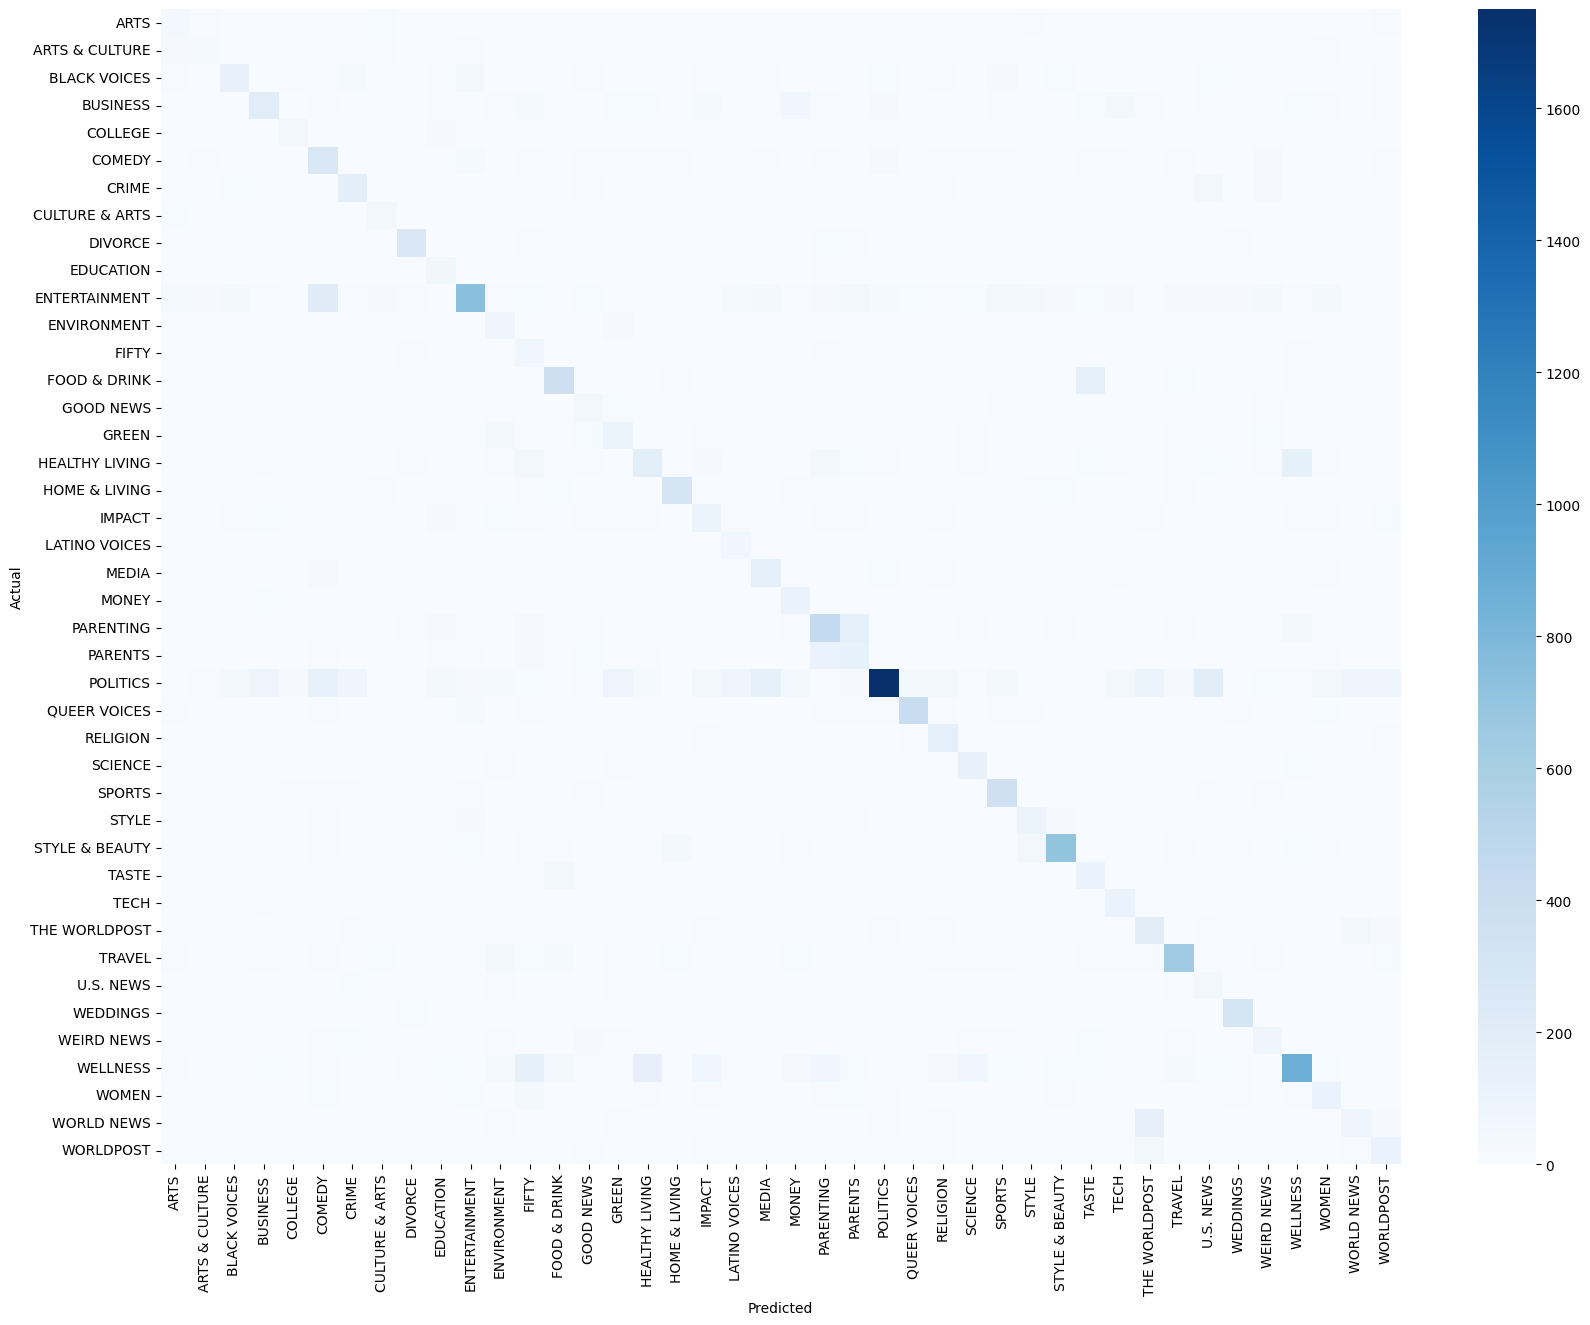

In [9]:
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_names = label_encoder.classes_

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(20, 15))
sns.heatmap(conf_mat, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)

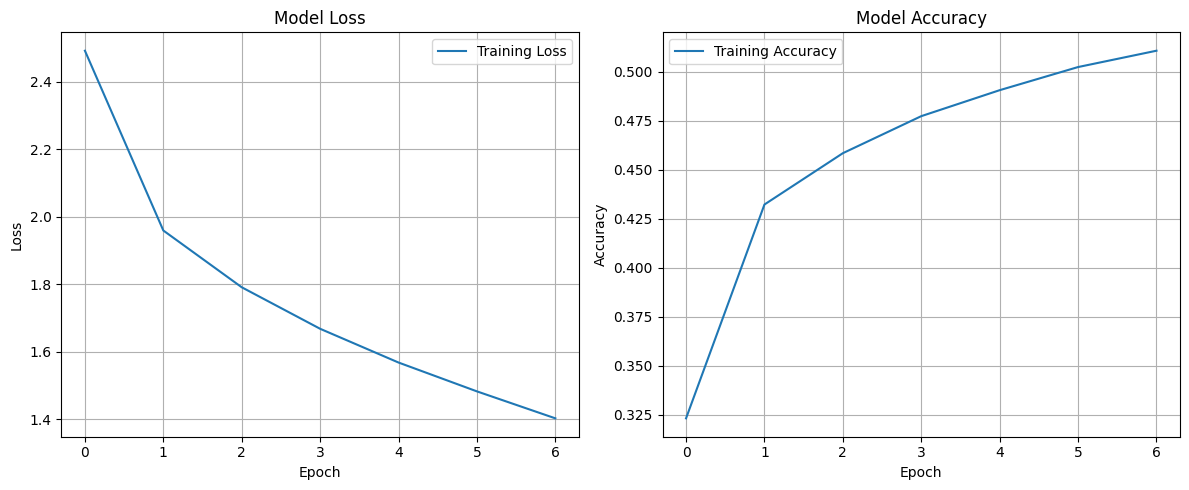

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()